### Mise en place de suivi par mlflow:

In [ ]:
#parfois si mlflow ne se connecte pas il faut essayer de redémarer le serveur mlflow
#avec la commande suivante sur un terminal
# anaconda prompt par exemple:  mlflow server --host 0.0.0.0 --port 5000

In [65]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import joblib
import mlflow

In [66]:
best_lgbmc = joblib.load("LGBM_best_model.joblib")
best_parameters = joblib.load("best_params_lgbmc_credit.joblib")

X_train_scaled = joblib.load("X_train_scaled.joblib")
X_test_scaled = joblib.load("X_test_scaled.joblib")
y_test = joblib.load('y_test.joblib')
y_train = joblib.load('y_train.joblib')

In [67]:
from sklearn import metrics
def metric_banking(y_test,y_pred):
    from sklearn import metrics
    cm = metrics.confusion_matrix(y_test, y_pred)
    metric = (10*cm[1,0] + cm[0,1]) / (cm[0,0] + cm[1,1] + 10*cm[1,0] + cm[0,1])
    return 1 - metric

#sklearn make_scorer for the banque_score
credit_score = metrics.make_scorer(metric_banking, greater_is_better = False)




def eval_metrics(y_true, y_pred_prob, seuil_proba):
    auc_score = roc_auc_score(y_true, y_pred_prob)
    pred = np.where(y_pred_prob > seuil_proba, 1, 0)
    score = metric_banking(y_true, pred)
    f1score = f1_score(y_true, pred, average='weighted')
    return auc_score, score, f1score


In [68]:
import matplotlib.cm
def plot_confusion_matrix(
    cm, class_names, title="Confusion matrix", cmap=matplotlib.cm.Blues, normalize=False
):
    """
    This function plots the confusion matrix.
    """

    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation="nearest", cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(
        xticks=np.arange(cm.shape[1]),
        yticks=np.arange(cm.shape[0]),
        ylim=(cm.shape[0] - 0.5, -0.5),
        xticklabels=class_names,
        yticklabels=class_names,
        title=title,
        xlabel="Ground truth label",
        ylabel="Predicted label",
    )

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=30,
             ha="right", rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = ".2f"
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(
                j,
                i,
                format(cm[i, j], fmt),
                ha="center",
                va="center",
                color="white" if cm[i, j] > thresh else "black",
            )
    fig.tight_layout()
    return ax, fig

In [69]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

def create_roc_plot(fpr, tpr):
    """
    Create ROC curve.
    :param fpr: false positive.
    :param tpr: true positive.
    :return: returns a tuple of plt, fig, ax
    """
    # Calculate AUC score
    probs_lgbmc = best_lgbmc.predict_proba(X_test_scaled)[:, 1]
    auc_score = roc_auc_score(y_test, probs_lgbmc)
    
    fig, ax = plt.subplots(nrows=1, ncols=1)
    ax.plot(fpr, tpr, label=f'AUC = {auc_score:.3f}')
    ax.plot([0, 1], [0, 1], linestyle='--', label='Random guess')
    ax.set_xlabel('False positive rate')
    ax.set_ylabel('True positive rate')
    ax.set_title('ROC curve')
    ax.legend()
    
    
    
    return plt, fig, ax

Setuptools is replacing distutils.


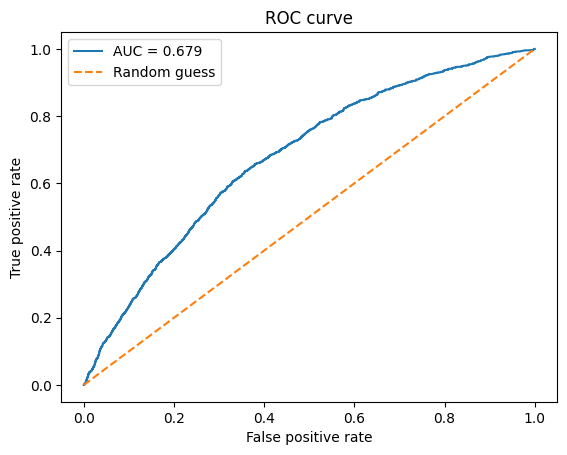

In [70]:
mlflow.set_tracking_uri("http://127.0.0.1:5000")
from sklearn import metrics
from sklearn.metrics import roc_curve, f1_score
mlflow.set_experiment('LGBMC optimisé sur le score métier')
with mlflow.start_run(run_name='LGBMC avec les meilleurs hyper-paramettres') as run:
   
    best_1 = joblib.load("best_params_lgbmc_credit.joblib")    
    
    y_pred_prob = best_lgbmc.predict_proba(X_test_scaled)[:, 1]

    plot_file = "roc-auc-plot.png"
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    plt_roc, fig_roc, ax_roc = create_roc_plot(fpr, tpr)
    fig_roc.savefig(plot_file)

    seuil = 0.50
    (auc_score, score, f1score) = eval_metrics(y_test, y_pred_prob, seuil)

    pred = np.where(y_pred_prob > seuil, 1, 0)

    class_names = ["Solvable", "Non Solvable"]
    confusion_matrix = metrics.confusion_matrix(y_test, pred)
    
    

    ax, fig = plot_confusion_matrix(
    confusion_matrix, class_names, normalize=False)
    plt.savefig("confusion_matrix.png")
    plt.close(fig)

#------------------------------------------------------------------------------------------   
    #mlflow.log_dict(best_1, "best_params.json")
    if not best_1 == None:
            for param in best_1:
                mlflow.log_param(param, best_1[param]) 
#--------------------------------------------------------------------------    
    mlflow.log_metric("metric_banking", score)
    mlflow.log_metric("AUC", auc_score)
    mlflow.log_metric("f1_score", f1score)
    mlflow.log_artifact("confusion_matrix.png")
    mlflow.log_artifact(plot_file, "roc-auc-plots")
    mlflow.sklearn.log_model(best_lgbmc, "best_lgbmc")
mlflow.end_run()

In [ ]:
#test du fichier app.py du dashboard

In [78]:
model = best_lgbmc
path = "C:/Users/aella/Desktop/apprentissage_data_science/Openclassrooms/projet7/projet7_github_Abdoullatuf_Maoulida/"
df_dash_10 = pd.read_csv(path + "df_dash_10.csv")
#X_test_10 = pd.read_csv(path +"X_test_10.csv")

In [25]:
df_dash_10.head()

,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,...,CC_NAME_CONTRACT_STATUS_Sentproposal_MAX,CC_NAME_CONTRACT_STATUS_Sentproposal_MEAN,CC_NAME_CONTRACT_STATUS_Sentproposal_SUM,CC_NAME_CONTRACT_STATUS_Signed_MIN,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_COUNT,prediction,proba
0,101779,0,1,0,0,0,202500.0,948582.0,27864.0,0.018634,...,0,0.0,0,0,0,0.000000,0,40,1,0.540450
1,402176,0,1,0,0,0,180000.0,1345036.5,39456.0,0.010276,...,0,0.0,0,0,1,0.011111,1,90,1,0.503965
2,209534,0,1,0,0,0,270000.0,1197378.0,43137.0,0.005313,...,0,0.0,0,0,0,0.000000,0,16,1,0.598620
3,345027,0,0,1,0,2,630000.0,1800000.0,68692.5,0.032561,...,0,0.0,0,0,0,0.000000,0,14,0,0.492683
4,131363,0,1,1,0,1,121500.0,499221.0,25618.5,0.008474,...,0,0.0,0,0,0,0.000000,0,21,1,0.554732


In [76]:
data_client = df_dash_10.loc[df_dash_10 ["SK_ID_CURR"] == 384006]

In [86]:
X = data_client.drop(["SK_ID_CURR", "TARGET", "prediction", "proba"], axis=1)
proba = model.predict_proba(X)[:, 1][0]

In [87]:
proba

0.5096886030360462

In [90]:
prediction = model.predict(X)
prediction[0]

1

In [59]:
client_index = data_client.index.item()
client_index

4

In [62]:
X_shap = df_dash_10.drop(["SK_ID_CURR", "TARGET", "prediction", "proba"], axis=1)

In [63]:
X_courant = X_shap.iloc[client_index]
X_courant

CODE_GENDER                                 1.0
FLAG_OWN_CAR                                1.0
FLAG_OWN_REALTY                             0.0
CNT_CHILDREN                                1.0
AMT_INCOME_TOTAL                       121500.0
                                         ...   
CC_NAME_CONTRACT_STATUS_Signed_MIN          0.0
CC_NAME_CONTRACT_STATUS_Signed_MAX          0.0
CC_NAME_CONTRACT_STATUS_Signed_MEAN         0.0
CC_NAME_CONTRACT_STATUS_Signed_SUM          0.0
CC_COUNT                                   21.0
Name: 4, Length: 490, dtype: float64

In [64]:
X_courant_array = X_courant.values.reshape(1, -1)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_courant_array)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


In [1]:
ipython --version

NameError: name 'ipython' is not defined